#### This notebook does the preprocessing and visualization of the data
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import rasterio
import textwrap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.font_manager as fm
import random
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
#import py3dep
import pyproj
from pyproj import CRS
import os
import warnings
import subprocess
from tqdm import tqdm
from watermark import watermark
import datetime

In [3]:
%%time

# Define file paths
base_dir=r'D:\culvert repo\data\initial layers'
state_shapefile_path = rf"{base_dir}\state_5070.shp"
stream_shapefile_path = rf"{base_dir}\stream_5070.shp"
stream_highres_shapefile_path = rf"{base_dir}\stream_highres_5070.shp"
road_shapefile_path = rf"{base_dir}\road_5070.shp"
street_shapefile_path = rf"{base_dir}\streets_5070.shp"
railroad_shapefile_path = rf"{base_dir}\railroad_NYS_cliped.shp"
culvert_shapefile_path = rf"{base_dir}\culvert_5070.shp"
HUC12_shapefile_path = rf"{base_dir}\HUC_12_5070.shp"
DEM_path = rf"{base_dir}\NYS_DEM_5070.tif"
bridge_path = rf"{base_dir}\NYSDOT_Bridges.shp"

# Load shapefiles
state_shapefile = gpd.read_file(state_shapefile_path)
stream_shapefile= gpd.read_file(stream_shapefile_path)
stream_highres_shapefile=gpd.read_file(stream_shapefile_path)
road_shapefile= gpd.read_file(road_shapefile_path)
street_shapefile= gpd.read_file(street_shapefile_path)
railroad_shapefile=gpd.read_file(railroad_shapefile_path).to_crs(epsg=5070)
culvert_shapefile=gpd.read_file(culvert_shapefile_path)
HUC12_shapfile=gpd.read_file(HUC12_shapefile_path)
bridge_shapefile=gpd.read_file(bridge_path).to_crs(epsg=5070)

c:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


CPU times: total: 49 s
Wall time: 56.5 s


In [ ]:
culvert_shapefile.shape

#### Drop duplicates

In [4]:
# Drop duplicates based on the 'BIN' column and report the number of duplicated rows
initial_culvert_rows = len(culvert_shapefile)
initial_bridge_rows = len(bridge_shapefile)

# Drop duplicates 
culvert_shapefile = culvert_shapefile.drop_duplicates(subset='BIN', keep='first')
bridge_shapefile = bridge_shapefile.drop_duplicates(subset='BIN', keep='first')

# Calculate the number of dropped rows
dropped_culvert_rows = initial_culvert_rows - len(culvert_shapefile)
dropped_bridge_rows = initial_bridge_rows - len(bridge_shapefile)

# Report the number of dropped rows
print(f"The number of rows in culvert dataset is {initial_culvert_rows}, and number of duplicate rows dropped from culvert_shapefile: {dropped_culvert_rows}")
print(f"The number of rows in bridge dataset is {initial_bridge_rows}, and number of duplicate rows dropped from bridge_shapefile: {dropped_bridge_rows}")

The number of rows in culvert dataset is 8561, and number of duplicate rows dropped from culvert_shapefile: 499
The number of rows in bridge dataset is 20027, and number of duplicate rows dropped from bridge_shapefile: 11


# Plot

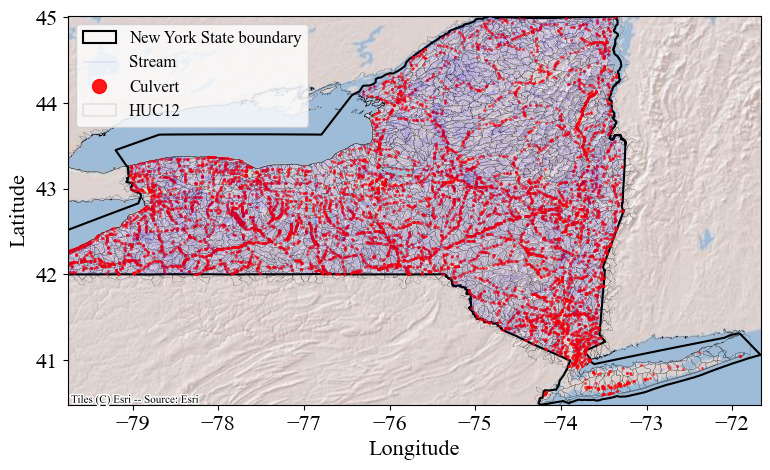

CPU times: total: 33.1 s
Wall time: 34.4 s


In [4]:
%%time
# Ensure all shapefiles are in EPSG:3857 for compatibility with contextily basemaps
state_shapefile = state_shapefile.to_crs(epsg=4326)
road_shapefile = road_shapefile.to_crs(epsg=4326)
culvert_shapefile = culvert_shapefile.to_crs(epsg=4326)
stream_shapefile = stream_shapefile.to_crs(epsg=4326)
HUC12_shapfile=HUC12_shapfile.to_crs(epsg=4326)
bridge_shapefile=bridge_shapefile.to_crs(epsg=4326)
railroad_shapefile=railroad_shapefile.to_crs(epsg=4326)
street_shapefile=street_shapefile.to_crs(epsg=4326)
stream_highres_shapefile=stream_highres_shapefile.to_crs(epsg=4326)
# Set the font for the plot
font={'family': 'Times New Roman', 'size': 16}
plt.rc('font', **font)  

# find perfect aspect ratio
minx, miny, maxx, maxy = state_shapefile.total_bounds
data_width = maxx - minx
data_height = maxy - miny
aspect_ratio = data_width / data_height
fig_width = 9
fig_height = fig_width / aspect_ratio
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Set axis limits
minx, miny, maxx, maxy = state_shapefile.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
# Axis labels 
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

### Plot
# State
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none', label='New York State boundary')
# HUC12
HUC12_shapfile.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor='none', label='HUC12')
# Street
#street_shapefile.plot(ax=ax, color='brown', linewidth=0.3, alpha=0.4*0.5, label='Street')
# Road
#road_shapefile.plot(ax=ax, color='orange', linewidth=0.5, alpha=0.4*0.5, label='Road')
# railroad
#railroad_shapefile.plot(ax=ax, color='black', linewidth=1, alpha=0.4*0.5, linestyle='dashed', label='Railroad')
# Bridge
#bridge_shapefile.plot(ax=ax, color='brown', markersize=1, alpha=0.3*0.5, marker='*', linestyle='None', label='Bridge')
# Culvert
culvert_shapefile.plot(ax=ax, color='red', markersize=1.5, alpha=0.5, marker='o', linestyle='None', label='Culvert')
# Stream
stream_shapefile.plot(ax=ax, color='blue', linewidth=0.1, alpha=0.5, label='Stream')

# Add basemap 
ctx.add_basemap(
    ax,
    crs=state_shapefile.crs,
    source=ctx.providers.Esri.WorldShadedRelief 
    #source=ctx.providers.NASAGIBS.ASTER_GDEM_Greyscale_Shaded_Relief
)

# legend handles
legend_handles = [
    mpatches.Patch(edgecolor='black', facecolor='none', linewidth=1.5, label='New York State boundary'),
    #Line2D([0], [0], color='brown', lw=0.3, alpha=0.7, label='Street'),
    #Line2D([0], [0], color='orange', lw=0.5, alpha=0.7, label='Road'),
    #Line2D([0], [0], color='black', lw=1, alpha=0.7, linestyle='dashed', label='Railroad'),
    Line2D([0], [0], color='blue', lw=0.3, alpha=0.3, label='Stream'),
    Line2D([0], [0], marker='o', color='red', markersize=10, alpha=0.9, linestyle='None', label='Culvert'),
    #Line2D([0], [0], marker='*', color='brown', markersize=4, alpha=0.7, linestyle='None', label='Bridge'),
    mpatches.Patch(edgecolor='black', facecolor='none', linewidth=0.1, label='HUC12')
]

# legend 
legend = ax.legend(handles=legend_handles, loc='upper left', prop={'family': 'Times New Roman', 'size': 12}, frameon=True)

# Scale bar (not working properly because of the 4326 crs in not in meters.) 
#scalebar = ScaleBar(10, units="m", dimension="si-length", location="lower left", scale_loc="bottom")
#ax.add_artist(scalebar)

# Save
plt.savefig(r'D:\culvert repo\Results\Figures\initial_layers_basemap.png', dpi=300)

# Display
plt.show()

In [12]:
street_3857   = street_shapefile.to_crs(epsg=3857)     # NEW
railroad_3857 = railroad_shapefile.to_crs(epsg=3857)   # NEW

In [8]:
import geopandas as gpd
import numpy as np

# ------------------------
# Simplify streams (in meters) + drop very short segments
# ------------------------
def simplify_lines(gdf, tol_m=50, min_len_m=100, work_crs="EPSG:5070"):
    """
    Simplify linework using Douglas-Peucker in a metric CRS.
    tol_m:      simplification tolerance in meters
    min_len_m:  drop line features shorter than this (meters)
    work_crs:   CRS used for simplification (meters)
    """
    if gdf.empty:
        return gdf

    # Remember original CRS
    orig_crs = gdf.crs

    # Reproject to a metric CRS (use your DEM’s CRS if handy; 5070 is great for NYS-scale)
    gp = gdf.to_crs(work_crs)

    # Simplify; preserve_topology=False is faster and generally fine for lines
    gp = gp[gp.geometry.notnull()].copy()
    gp["geometry"] = gp.geometry.simplify(tol_m, preserve_topology=False)

    # Drop empties and very short segments (units = meters in work_crs)
    gp = gp[gp.geometry.notnull() & ~gp.geometry.is_empty].copy()
    gp["len_m"] = gp.length
    gp = gp[gp["len_m"] >= min_len_m].drop(columns="len_m")

    # Back to original CRS for plotting alongside other layers
    return gp.to_crs(orig_crs)

# Make a simplified copy of your streams
# Tweak tol/min_len to your map scale; start with tol=50–150 m, min_len=100–300 m.
stream_shapefile_simple = simplify_lines(stream_shapefile, tol_m=100, min_len_m=300)
street_shapefile_simple = simplify_lines(street_shapefile, tol_m=100, min_len_m=300)



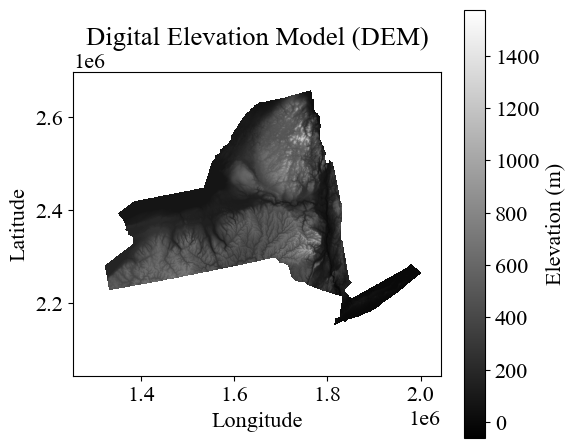

In [5]:
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np

DEM_path = rf"{base_dir}\NYS_DEM_5070.tif"

with rasterio.open(DEM_path) as src:
    H, W = src.height, src.width
    bounds = src.bounds

    # Downsample to manageable size
    target_pixels = 6_000_000
    scale = max(1.0, np.sqrt((H * W) / target_pixels))
    out_h = max(1, int(H / scale))
    out_w = max(1, int(W / scale))

    # Read downsampled and masked
    dem = src.read(
        1,
        out_shape=(out_h, out_w),
        resampling=Resampling.average,
        masked=True,
    ).astype("float32")

extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# Black–white colormap
cmap = plt.get_cmap("gray").copy()
cmap.set_bad(alpha=0)   # make NoData transparent

plt.figure(figsize=(6, 5))
plt.imshow(dem, cmap=cmap, extent=extent, origin="upper")
plt.colorbar(label="Elevation (m)")
plt.title("Digital Elevation Model (DEM)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


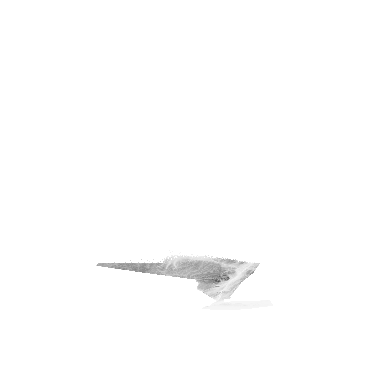

In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# ------------------------
# Load DEM (downsampled + masked)
# ------------------------
with rasterio.open(DEM_path) as src:
    H, W = src.height, src.width
    bounds = src.bounds
    dem_crs = src.crs  # <-- use CRS of the DEM

    target_pixels = 6_000_000
    scale = max(1.0, np.sqrt((H * W) / target_pixels))
    out_h = max(1, int(H / scale))
    out_w = max(1, int(W / scale))

    dem = src.read(
        1,
        out_shape=(out_h, out_w),
        resampling=Resampling.average,
        masked=True,
    ).astype("float32")

extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# ------------------------
# Reproject vectors to DEM CRS (fixes the offset)
# ------------------------
state_shapefile = state_shapefile.to_crs(dem_crs)
HUC12_shapfile = HUC12_shapfile.to_crs(dem_crs)
stream_shapefile_simple = stream_shapefile_simple.to_crs(dem_crs)
culvert_shapefile = culvert_shapefile.to_crs(dem_crs)

# ------------------------
# Define layers (DEM first so others overlay on top)
# ------------------------
layers = [
    ("DEM", dem, {"cmap": "gray_r", "alpha": 0.5}),
    #("Basemap", state_shapefile, {"edgecolor": "black", "facecolor": "none", "linewidth": 0.5}),
    #("HUC12", HUC12_shapfile, {"edgecolor": "black", "facecolor": "none", "linewidth": 0.2, "alpha": 0.6}),
    #("Stream", stream_shapefile_simple, {"color": "blue", "linewidth": 0.15, "alpha": 0.5}),
    #("Culverts", culvert_shapefile, {"color": "red", "s": 2, "alpha": 0.7, "marker": "o", "linewidth": 0}),
]

# ------------------------
# Helpers
# ------------------------
def style_for_line(style: dict) -> dict:
    out = {}
    out["color"] = style.get("color", style.get("edgecolor", "k"))
    out["linewidth"] = style.get("linewidth", 0.2)
    if "linestyle" in style:
        out["linestyle"] = style["linestyle"]
    if "alpha" in style:
        out["alpha"] = style["alpha"]
    out.setdefault("zorder", 5)  # keep vectors visually on top
    return out

def style_for_scatter(style: dict) -> dict:
    out = {}
    out["c"] = style.get("color", style.get("edgecolor", "k"))
    out["s"] = style.get("s", 1)
    if "marker" in style:
        out["marker"] = style["marker"]
    if "alpha" in style:
        out["alpha"] = style["alpha"]
    out["linewidths"] = style.get("linewidth", 0)
    out.setdefault("zorder", 6)
    return out

# ------------------------
# Use DEM bounds for axes (so everything lines up)
# ------------------------
minx, miny, maxx, maxy = bounds.left, bounds.bottom, bounds.right, bounds.top

# ------------------------
# Make 3D figure
# ------------------------
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection="3d")

z_spacing = 0.015 * (maxy - miny)

# ------------------------
# Plot layers
# ------------------------
for i, (label, data, base_style) in enumerate(layers):
    base_z = i * z_spacing

    # ✅ minimal fix: keep DEM above 0 (not negative)
    z_level = base_z if label == "DEM" else base_z + 1e-6

    if label == "DEM":
        # Flip DEM vertically so it matches imshow(origin="upper") convention
        #data_plot = np.flipud(data)
        data_plot = data
        # Build grid in DEM coords
        nrows, ncols = data_plot.shape
        xs = np.linspace(extent[0], extent[1], ncols)
        ys = np.linspace(extent[2], extent[3], nrows)
        X, Y = np.meshgrid(xs, ys)

        # Colormap with transparent NoData
        cmap = plt.get_cmap(base_style.get("cmap", "gray_r")).copy()
        cmap.set_bad(alpha=0)

        # Normalize and map to RGBA; keep NoData transparent
        norm = Normalize(vmin=np.nanmin(data_plot), vmax=np.nanmax(data_plot))
        rgba = cmap(norm(np.ma.filled(data_plot, np.nan)))

        # 50% alpha for valid pixels, 0 for NoData
        if np.ma.is_masked(data_plot):
            rgba[..., -1] = np.where(data_plot.mask, 0.0, 0.5)
        else:
            rgba[..., -1] = 0.5

        ax.plot_surface(
            X, Y, np.full_like(data_plot, z_level, dtype=float),
            facecolors=rgba, rstride=1, cstride=1,
            linewidth=0, antialiased=False, shade=False,
            alpha=base_style.get("alpha", 1.0),
            zorder=0,
        )

    else:
        # Handle vector layers
        line_kwargs = style_for_line(base_style)
        scat_kwargs = style_for_scatter(base_style)

        for geom in data.geometry:
            if geom is None:
                continue
            gt = geom.geom_type
            if gt == "Polygon":
                xs, ys = geom.exterior.xy
                ax.plot(xs, ys, z_level, **line_kwargs)
                for interior in geom.interiors:
                    xs, ys = interior.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "MultiPolygon":
                for poly in geom.geoms:
                    xs, ys = poly.exterior.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
                    for interior in poly.interiors:
                        xs, ys = interior.xy
                        ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "LineString":
                xs, ys = geom.xy
                ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "MultiLineString":
                for line in geom.geoms:
                    xs, ys = line.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "Point":
                ax.scatter([geom.x], [geom.y], [z_level], **scat_kwargs)
            elif gt == "MultiPoint":
                xs = [p.x for p in geom.geoms]
                ys = [p.y for p in geom.geoms]
                zs = [z_level] * len(xs)
                ax.scatter(xs, ys, zs, **scat_kwargs)

# ------------------------
# Styling
# ------------------------
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_zlim(0, len(layers) * z_spacing)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_zticks([])
ax.set_zticklabels([])
ax.zaxis.line.set_visible(False)
ax.set_zlabel("")

ax.view_init(elev=25, azim=-60)
ax.grid(False)
ax.set_axis_off()
plt.tight_layout()
plt.show()


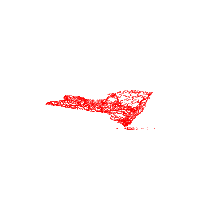

In [16]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# ------------------------
# Load DEM (downsampled + masked)
# ------------------------
with rasterio.open(DEM_path) as src:
    H, W = src.height, src.width
    bounds = src.bounds
    dem_crs = src.crs  # use CRS of the DEM

    target_pixels = 6_000_000
    scale = max(1.0, np.sqrt((H * W) / target_pixels))
    out_h = max(1, int(H / scale))
    out_w = max(1, int(W / scale))

    dem = src.read(
        1,
        out_shape=(out_h, out_w),
        resampling=Resampling.average,
        masked=True,             # ok to read masked; we won't use mask for alpha
    ).astype("float32")

extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# ------------------------
# Reproject vectors to DEM CRS (if you plot them)
# ------------------------
state_shapefile = state_shapefile.to_crs(dem_crs)
HUC12_shapfile = HUC12_shapfile.to_crs(dem_crs)
stream_shapefile_simple = stream_shapefile_simple.to_crs(dem_crs)
culvert_shapefile = culvert_shapefile.to_crs(dem_crs)
road_shapefile=road_shapefile.to_crs(dem_crs)
street_shapefile_simple=street_shapefile_simple.to_crs(dem_crs)
railroad_shapefile=railroad_shapefile.to_crs(dem_crs)

# ------------------------
# Define layers (DEM first so others overlay on top)
# ------------------------
layers = [
    #("DEM", dem, {"cmap": "gray_r"}),  # alpha handled below; keep opaque
    #("Basemap", state_shapefile, {"edgecolor": "black", "facecolor": "none", "linewidth": 0.5}),
    #("HUC12", HUC12_shapfile, {"edgecolor": "darkcyan", "facecolor": "none", "linewidth": 0.2, "alpha": 0.6}),
    #("Road", road_shapefile, {"edgecolor": "orange", "facecolor": "none", "linewidth": 0.2, "alpha": 0.6}),
    #("Street", street_shapefile_simple, {"edgecolor": "brown", "facecolor": "none", "linewidth": 0.05, "alpha": 0.6}),
    #("Railroad", railroad_shapefile, {"edgecolor": "dimgray", "facecolor": "none", "linewidth": 0.25, "alpha": 0.6}),
    #("Stream", stream_shapefile_simple, {"color": "blue", "linewidth": 0.05, "alpha": 1}),
    ("Culverts", culvert_shapefile, {"color": "red", "s": 0.1, "alpha": 1, "marker": "o", "linewidth": 0}),
]

# ------------------------
# Helpers
# ------------------------
def style_for_line(style: dict) -> dict:
    out = {}
    out["color"] = style.get("color", style.get("edgecolor", "k"))
    out["linewidth"] = style.get("linewidth", 0.2)
    if "linestyle" in style:
        out["linestyle"] = style["linestyle"]
    if "alpha" in style:
        out["alpha"] = style["alpha"]
    out.setdefault("zorder", 5)
    return out

def style_for_scatter(style: dict) -> dict:
    out = {}
    out["c"] = style.get("color", style.get("edgecolor", "k"))
    out["s"] = style.get("s", 1)
    if "marker" in style:
        out["marker"] = style["marker"]
    if "alpha" in style:
        out["alpha"] = style["alpha"]
    out["linewidths"] = style.get("linewidth", 0)
    out.setdefault("zorder", 6)
    return out

# ------------------------
# Axes extents (XY from DEM bounds)
# ------------------------
minx, miny, maxx, maxy = bounds.left, bounds.bottom, bounds.right, bounds.top

# ------------------------
# Make 3D figure
# ------------------------
fig = plt.figure(figsize=(3, 2.5))
ax = fig.add_subplot(111, projection="3d")
# Optional: remove perspective distortion
# ax.set_proj_type('ortho')
VERTICAL_GAP = 0.06
z_spacing = VERTICAL_GAP * (maxy - miny)

# ------------------------
# Plot layers
# ------------------------
for i, (label, data, base_style) in enumerate(layers):
    base_z = i * z_spacing
    z_level = base_z if label == "DEM" else base_z + 1e-6  # DEM at base; vectors slightly above

    if label == "DEM":
        data_plot = np.flipud(data)
        # Build grid in DEM coords (no flip needed if origin is lower-left in 3D)
        nrows, ncols = data_plot.shape
        xs = np.linspace(extent[0], extent[1], ncols)
        ys = np.linspace(extent[2], extent[3], nrows)
        X, Y = np.meshgrid(xs, ys)

        # Color map WITHOUT per-pixel transparency (opaque to avoid 3D alpha artifacts)
        norm = Normalize(vmin=np.nanmin(data_plot), vmax=np.nanmax(data_plot))
        rgba = plt.get_cmap(base_style.get("cmap", "gray_r"))(norm(np.ma.filled(data_plot, np.nan)))
        rgba[..., -1] = 1.0  # opaque

        surf = ax.plot_surface(
            X, Y, np.full_like(data_plot, z_level, dtype=float),
            facecolors=rgba, rstride=1, cstride=1,
            linewidth=0, antialiased=False, shade=False,
            zorder=0,
        )
        # If you *must* keep alpha, also try: surf.set_zsort('min')

    else:
        # Vectors
        line_kwargs = style_for_line(base_style)
        scat_kwargs = style_for_scatter(base_style)
        for geom in data.geometry:
            if geom is None:
                continue
            gt = geom.geom_type
            if gt == "Polygon":
                xs, ys = geom.exterior.xy
                ax.plot(xs, ys, z_level, **line_kwargs)
                for interior in geom.interiors:
                    xs, ys = interior.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "MultiPolygon":
                for poly in geom.geoms:
                    xs, ys = poly.exterior.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
                    for interior in poly.interiors:
                        xs, ys = interior.xy
                        ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "LineString":
                xs, ys = geom.xy
                ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "MultiLineString":
                for line in geom.geoms:
                    xs, ys = line.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "Point":
                ax.scatter([geom.x], [geom.y], [z_level], **scat_kwargs)
            elif gt == "MultiPoint":
                xs = [p.x for p in geom.geoms]
                ys = [p.y for p in geom.geoms]
                zs = [z_level] * len(xs)
                ax.scatter(xs, ys, zs, **scat_kwargs)

# ------------------------
# Styling
# ------------------------
# tiny padding to avoid edge clipping
padx = 0.005 * (maxx - minx)
pady = 0.005 * (maxy - miny)
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_zlim(0, len(layers) * z_spacing)

# Make XY dominate so the DEM fills the frame
ax.set_box_aspect((maxx - minx, maxy - miny, z_spacing * len(layers)))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zticks([]); ax.set_zticklabels([])
ax.zaxis.line.set_visible(False)
ax.set_zlabel("")

ax.view_init(elev=25, azim=-60)
ax.grid(False)
ax.set_axis_off()

# Avoid tight_layout in 3D; it often crops artists
# plt.tight_layout()
plt.savefig(r'C:\Users\Omid Emamjomehzadeh\Desktop\data figures\Culverts.png',
            dpi=1000, bbox_inches='tight')
plt.show()

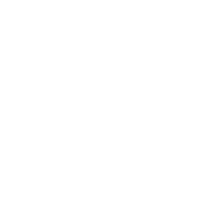

In [13]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling as WarpResampling, transform_bounds
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
# import geopandas as gpd  # if you need it for vectors already loaded elsewhere

# ------------------------
# Paths
# ------------------------
hydrologic_soil_path = r"D:\culvert repo\data\initial layers\hydrologic_soil_group_5070.tif"

# ------------------------
# Load DEM (downsampled + masked)
# ------------------------
with rasterio.open(DEM_path) as src:
    H, W = src.height, src.width
    bounds = src.bounds
    dem_crs = src.crs

    target_pixels = 6_000_000
    scale = max(1.0, np.sqrt((H * W) / target_pixels))
    out_h = max(1, int(H / scale))
    out_w = max(1, int(W / scale))

    dem = src.read(
        1,
        out_shape=(out_h, out_w),
        resampling=Resampling.average,
        masked=True,
    ).astype("float32")

extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# ------------------------
# Read Hydrologic Soil Group raster (categorical)
# ------------------------
soil_groups = {1:"A", 2:"B", 3:"C", 4:"D", 5:"A/D", 6:"B/D", 7:"C/D"}
hsg_colors = {
    1:"#ffd966", 2:"#fad689", 3:"#e0c9a6", 4:"#d9ead3",
    5:"#92cddc", 6:"#f0c3a0", 7:"#f2b5d4"
}
hsg_cmap = mcolors.ListedColormap([hsg_colors[k] for k in sorted(hsg_colors.keys())])
hsg_bounds = np.arange(1, 9) - 0.5
hsg_norm = mcolors.BoundaryNorm(hsg_bounds, hsg_cmap.N)

with rasterio.open(hydrologic_soil_path) as hs:
    HH, WW = hs.height, hs.width
    target_pixels = 6_000_000
    hsg_scale = max(1.0, np.sqrt((HH * WW) / target_pixels))
    hsg_out_h = max(1, int(HH / hsg_scale))
    hsg_out_w = max(1, int(WW / hsg_scale))

    hsg_native = hs.read(1, out_shape=(hsg_out_h, hsg_out_w), resampling=Resampling.nearest)
    hsg_native = np.ma.masked_equal(hsg_native, hs.nodata)

    if hs.crs != dem_crs:
        dem_bounds_like = transform_bounds(hs.crs, dem_crs, *hs.bounds)
        dst_transform = rasterio.transform.from_bounds(*dem_bounds_like, hsg_out_w, hsg_out_h)
        hsg = np.empty((hsg_out_h, hsg_out_w), dtype=hsg_native.dtype)
        reproject(
            source=hsg_native.filled(0),  # 0 is outside class range; we’ll mask later
            destination=hsg,
            src_transform=hs.transform,
            src_crs=hs.crs,
            dst_transform=dst_transform,
            dst_crs=dem_crs,
            resampling=WarpResampling.nearest,
        )
        hsg = np.ma.masked_where((hsg == hs.nodata) | (hsg == 0), hsg)
        hsg_extent = (dem_bounds_like[0], dem_bounds_like[2], dem_bounds_like[1], dem_bounds_like[3])
    else:
        hsg = hsg_native
        b = hs.bounds
        hsg_extent = (b.left, b.right, b.bottom, b.top)

# ------------------------
# Reproject vectors to DEM CRS (already done in your code)
# ------------------------
state_shapefile = state_shapefile.to_crs(dem_crs)
HUC12_shapfile = HUC12_shapfile.to_crs(dem_crs)
stream_shapefile_simple = stream_shapefile_simple.to_crs(dem_crs)
culvert_shapefile = culvert_shapefile.to_crs(dem_crs)
road_shapefile = road_shapefile.to_crs(dem_crs)
street_shapefile_simple = street_shapefile_simple.to_crs(dem_crs)
railroad_shapefile = railroad_shapefile.to_crs(dem_crs)

# ------------------------
# Define layers (DEM first so others overlay on top)
# ------------------------
layers = [
    #("DEM", dem, {"cmap": "gray_r", "extent": extent}),
    ("HSG", hsg, {"cmap": hsg_cmap, "norm": hsg_norm, "extent": hsg_extent}),  # new raster layer
    #("Stream", stream_shapefile_simple, {"color": "blue", "linewidth": 0.05, "alpha": 1}),
    #("Culverts", culvert_shapefile, {"color": "red", "s": 0.1, "alpha": 1, "marker": "o", "linewidth": 0}),
]

# ------------------------
# Helpers
# ------------------------
def style_for_line(style: dict) -> dict:
    out = {}
    out["color"] = style.get("color", style.get("edgecolor", "k"))
    out["linewidth"] = style.get("linewidth", 0.2)
    if "linestyle" in style:
        out["linestyle"] = style["linestyle"]
    if "alpha" in style:
        out["alpha"] = style["alpha"]
    out.setdefault("zorder", 5)
    return out

def style_for_scatter(style: dict) -> dict:
    out = {}
    out["c"] = style.get("color", style.get("edgecolor", "k"))
    out["s"] = style.get("s", 1)
    if "marker" in style:
        out["marker"] = style["marker"]
    if "alpha" in style:
        out["alpha"] = style["alpha"]
    out["linewidths"] = style.get("linewidth", 0)
    out.setdefault("zorder", 6)
    return out

# ------------------------
# Axes extents (XY from DEM bounds)
# ------------------------
minx, miny, maxx, maxy = bounds.left, bounds.bottom, bounds.right, bounds.top

# ------------------------
# Make 3D figure
# ------------------------
fig = plt.figure(figsize=(3, 2.5))
ax = fig.add_subplot(111, projection="3d")
# ax.set_proj_type('ortho')

VERTICAL_GAP = 0.06
z_spacing = VERTICAL_GAP * (maxy - miny)

# ------------------------
# Plot layers
# ------------------------
for i, (label, data, base_style) in enumerate(layers):
    base_z = i * z_spacing
    z_level = base_z if label in ("DEM", "HSG") else base_z + 1e-6  # rasters at base; vectors above

    if label in ("DEM", "HSG"):
        data_plot = np.flipud(data)  # keep same orientation convention
        ext = base_style.get("extent", extent)

        nrows, ncols = data_plot.shape
        xs = np.linspace(ext[0], ext[1], ncols)
        ys = np.linspace(ext[2], ext[3], nrows)
        X, Y = np.meshgrid(xs, ys)

        # --- FIX: don't fill masked integer arr with NaN ---
        cmap = base_style.get("cmap", "gray_r")
        cmap = plt.get_cmap(cmap) if isinstance(cmap, str) else cmap
        norm = base_style.get("norm", Normalize(vmin=np.nanmin(data_plot), vmax=np.nanmax(data_plot)))

        rgba = cmap(norm(data_plot))          # pass masked array directly
        rgba = np.asarray(rgba)
        if np.ma.is_masked(data_plot):
            rgba[..., -1] = np.where(data_plot.mask, 0.0, 1.0)  # transparent only where masked
        else:
            rgba[..., -1] = 1.0

        ax.plot_surface(
            X, Y, np.full_like(data_plot, z_level, dtype=float),
            facecolors=rgba, rstride=1, cstride=1,
            linewidth=0, antialiased=False, shade=False,
            zorder=0,
        )

    else:
        line_kwargs = style_for_line(base_style)
        scat_kwargs = style_for_scatter(base_style)
        for geom in data.geometry:
            if geom is None:
                continue
            gt = geom.geom_type
            if gt == "Polygon":
                xs, ys = geom.exterior.xy
                ax.plot(xs, ys, z_level, **line_kwargs)
                for interior in geom.interiors:
                    xs, ys = interior.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "MultiPolygon":
                for poly in geom.geoms:
                    xs, ys = poly.exterior.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
                    for interior in poly.interiors:
                        xs, ys = interior.xy
                        ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "LineString":
                xs, ys = geom.xy
                ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "MultiLineString":
                for line in geom.geoms:
                    xs, ys = line.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "Point":
                ax.scatter([geom.x], [geom.y], [z_level], **scat_kwargs)
            elif gt == "MultiPoint":
                xs = [p.x for p in geom.geoms]
                ys = [p.y for p in geom.geoms]
                zs = [z_level] * len(xs)
                ax.scatter(xs, ys, zs, **scat_kwargs)

# ------------------------
# Styling
# ------------------------
padx = 0.005 * (maxx - minx)
pady = 0.005 * (maxy - miny)
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_zlim(0, len(layers) * z_spacing)

ax.set_box_aspect((maxx - minx, maxy - miny, z_spacing * len(layers)))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zticks([]); ax.set_zticklabels([])
ax.zaxis.line.set_visible(False)
ax.set_zlabel("")

ax.view_init(elev=25, azim=-60)
ax.grid(False)
ax.set_axis_off()

plt.savefig(r'C:\Users\Omid Emamjomehzadeh\Desktop\data figures\HSG.png',
            dpi=1000, bbox_inches='tight')
plt.show()


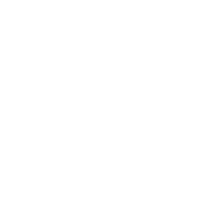

In [14]:
import rasterio
from rasterio.enums import Resampling
from rasterio import mask as rio_mask
from rasterio.warp import reproject, Resampling as WarpResampling, transform_bounds
import rasterio.transform as rio_transform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

# -------------------------------------------------
# INPUTS
# -------------------------------------------------
# your existing variables: DEM_path, state_shapefile, HUC12_shapfile,
# stream_shapefile_simple, culvert_shapefile, road_shapefile,
# street_shapefile_simple, railroad_shapefile
landuse_path = r"D:\hydrological analysis\data\CN\CONUS_Landcover\CONUS_Landcover_A2\CONUS_A2_y2100.tif"

# -------------------------------------------------
# DEM (downsampled + masked, CRS anchor)
# -------------------------------------------------
with rasterio.open(DEM_path) as src:
    H, W = src.height, src.width
    bounds = src.bounds
    dem_crs = src.crs

    target_pixels = 6_000_000
    scale = max(1.0, np.sqrt((H * W) / target_pixels))
    out_h = max(1, int(H / scale))
    out_w = max(1, int(W / scale))

    dem = src.read(
        1,
        out_shape=(out_h, out_w),
        resampling=Resampling.average,
        masked=True,
    ).astype("float32")

extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# -------------------------------------------------
# LANDUSE raster (clip to state, reproject to DEM CRS)
# -------------------------------------------------
# class colors (same as your 2D plot)
landuse_colors = {
    0: 'black',                 # Undefined
    1: 'blue',                  # Water
    2: 'red',                   # Developed
    3: 'burlywood',             # Mech. Dist. National Forests
    4: 'peachpuff',             # Mech. Dist. Other Public Lands
    5: 'tan',                   # Mech. Dist. Private
    6: 'brown',                 # Mining
    7: 'lightgray',             # Barren
    8: 'mediumseagreen',        # Deciduous Forest
    9: 'darkolivegreen',        # Evergreen Forest
    10: 'chartreuse',           # Mixed Forest
    11: 'lightgoldenrodyellow', # Grassland
    12: 'darkkhaki',            # Shrubland
    13: 'darkseagreen',         # Cropland
    14: 'palegreen',            # Hay/Pasture Land
    15: 'aquamarine',           # Herbaceous Wetland
    16: 'mediumaquamarine',     # Woody Wetland
    17: 'snow',                 # Perennial Ice/Snow
}
landuse_cmap = mcolors.ListedColormap([landuse_colors[k] for k in sorted(landuse_colors.keys())])
landuse_norm = mcolors.BoundaryNorm(np.arange(-0.5, 17.5+1, 1), landuse_cmap.N)

with rasterio.open(landuse_path) as lu_src:
    # mask geometries must be in lu_src.crs
    state_for_mask = state_shapefile.to_crs(lu_src.crs)
    out_img, out_transform = rio_mask.mask(lu_src, state_for_mask.geometry, crop=True)
    lu_nodata = lu_src.nodata

    # masked integer array (keep 0 as a valid class; mask real NoData only)
    landuse_native = np.ma.array(out_img[0], mask=(out_img[0] == lu_nodata) if lu_nodata is not None else False)

    # downsample budget similar to DEM
    HH, WW = landuse_native.shape
    target_pixels = 6_000_000
    lu_scale = max(1.0, np.sqrt((HH * WW) / target_pixels))
    lu_h = max(1, int(HH / lu_scale))
    lu_w = max(1, int(WW / lu_scale))

    # destination grid in DEM CRS covering the clipped landuse bounds
    left, bottom, right, top = rio_transform.array_bounds(HH, WW, out_transform)
    left_d, bottom_d, right_d, top_d = transform_bounds(lu_src.crs, dem_crs, left, bottom, right, top)
    lu_dst_transform = rio_transform.from_bounds(left_d, bottom_d, right_d, top_d, lu_w, lu_h)

    landuse = np.empty((lu_h, lu_w), dtype=landuse_native.dtype)
    reproject(
        source=landuse_native.filled(lu_nodata if lu_nodata is not None else 255),
        destination=landuse,
        src_transform=out_transform,
        src_crs=lu_src.crs,
        dst_transform=lu_dst_transform,
        dst_crs=dem_crs,
        resampling=WarpResampling.nearest,
    )
    # mask nodata AFTER reprojection (0 is a legit class)
    landuse = np.ma.array(landuse, mask=(landuse == lu_nodata) if lu_nodata is not None else False)
    landuse_extent = (left_d, right_d, bottom_d, top_d)

# -------------------------------------------------
# Reproject vectors to DEM CRS (for overlay)
# -------------------------------------------------
state_shapefile = state_shapefile.to_crs(dem_crs)
HUC12_shapfile = HUC12_shapfile.to_crs(dem_crs)
stream_shapefile_simple = stream_shapefile_simple.to_crs(dem_crs)
culvert_shapefile = culvert_shapefile.to_crs(dem_crs)
road_shapefile = road_shapefile.to_crs(dem_crs)
street_shapefile_simple = street_shapefile_simple.to_crs(dem_crs)
railroad_shapefile = railroad_shapefile.to_crs(dem_crs)

# -------------------------------------------------
# Layers (stack order)
# -------------------------------------------------
layers = [
    #("DEM", dem, {"cmap": "gray_r", "extent": extent}),
    ("Landuse", landuse, {"cmap": landuse_cmap, "norm": landuse_norm, "extent": landuse_extent}),
    # ("HUC12", HUC12_shapfile, {"edgecolor": "black", "facecolor": "none", "linewidth": 0.2, "alpha": 0.6}),
    # ("Road", road_shapefile, {"edgecolor": "orange", "facecolor": "none", "linewidth": 0.2, "alpha": 0.6}),
    # ("Street", street_shapefile_simple, {"edgecolor": "brown", "facecolor": "none", "linewidth": 0.05, "alpha": 0.6}),
    # ("Railroad", railroad_shapefile, {"edgecolor": "dimgray", "facecolor": "none", "linewidth": 0.25, "alpha": 0.6}),
    #("Stream", stream_shapefile_simple, {"color": "blue", "linewidth": 0.05, "alpha": 1}),
    #("Culverts", culvert_shapefile, {"color": "red", "s": 0.1, "alpha": 1, "marker": "o", "linewidth": 0}),
]

# -------------------------------------------------
# Style helpers
# -------------------------------------------------
def style_for_line(style: dict) -> dict:
    out = {}
    out["color"] = style.get("color", style.get("edgecolor", "k"))
    out["linewidth"] = style.get("linewidth", 0.2)
    if "linestyle" in style:
        out["linestyle"] = style["linestyle"]
    if "alpha" in style:
        out["alpha"] = style["alpha"]
    out.setdefault("zorder", 5)
    return out

def style_for_scatter(style: dict) -> dict:
    out = {}
    out["c"] = style.get("color", style.get("edgecolor", "k"))
    out["s"] = style.get("s", 1)
    if "marker" in style:
        out["marker"] = style["marker"]
    if "alpha" in style:
        out["alpha"] = style["alpha"]
    out["linewidths"] = style.get("linewidth", 0)
    out.setdefault("zorder", 6)
    return out

# -------------------------------------------------
# Axes extents (from DEM)
# -------------------------------------------------
minx, miny, maxx, maxy = extent[0], extent[2], extent[1], extent[3]

# -------------------------------------------------
# Figure
# -------------------------------------------------
fig = plt.figure(figsize=(3, 2.5))
ax = fig.add_subplot(111, projection="3d")
# ax.set_proj_type('ortho')  # optional

VERTICAL_GAP = 0.06
z_spacing = VERTICAL_GAP * (maxy - miny)

# -------------------------------------------------
# Plot
# -------------------------------------------------
for i, (label, data, base_style) in enumerate(layers):
    base_z = i * z_spacing
    z_level = base_z if label in ("DEM", "Landuse") else base_z + 1e-6  # rasters at base; vectors above

    if label in ("DEM", "Landuse"):
        data_plot = np.flipud(data)  # keep same orientation
        ext = base_style.get("extent", extent)

        nrows, ncols = data_plot.shape
        xs = np.linspace(ext[0], ext[1], ncols)
        ys = np.linspace(ext[2], ext[3], nrows)
        X, Y = np.meshgrid(xs, ys)

        cmap = base_style.get("cmap", "gray_r")
        cmap = plt.get_cmap(cmap) if isinstance(cmap, str) else cmap
        norm = base_style.get("norm", Normalize(vmin=np.nanmin(data_plot), vmax=np.nanmax(data_plot)))

        # map colors, keep masked cells transparent
        rgba = cmap(norm(data_plot))
        rgba = np.asarray(rgba)
        if np.ma.is_masked(data_plot):
            rgba[..., -1] = np.where(data_plot.mask, 0.0, 1.0)
        else:
            rgba[..., -1] = 1.0

        ax.plot_surface(
            X, Y, np.full_like(data_plot, z_level, dtype=float),
            facecolors=rgba, rstride=1, cstride=1,
            linewidth=0, antialiased=False, shade=False, zorder=0,
        )

    else:
        line_kwargs = style_for_line(base_style)
        scat_kwargs = style_for_scatter(base_style)
        for geom in data.geometry:
            if geom is None:
                continue
            gt = geom.geom_type
            if gt == "Polygon":
                xs, ys = geom.exterior.xy
                ax.plot(xs, ys, z_level, **line_kwargs)
                for interior in geom.interiors:
                    xs, ys = interior.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "MultiPolygon":
                for poly in geom.geoms:
                    xs, ys = poly.exterior.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
                    for interior in poly.interiors:
                        xs, ys = interior.xy
                        ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "LineString":
                xs, ys = geom.xy
                ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "MultiLineString":
                for line in geom.geoms:
                    xs, ys = line.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "Point":
                ax.scatter([geom.x], [geom.y], [z_level], **scat_kwargs)
            elif gt == "MultiPoint":
                xs = [p.x for p in geom.geoms]
                ys = [p.y for p in geom.geoms]
                zs = [z_level] * len(xs)
                ax.scatter(xs, ys, zs, **scat_kwargs)

# -------------------------------------------------
# Styling
# -------------------------------------------------
padx = 0.005 * (maxx - minx)
pady = 0.005 * (maxy - miny)
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_zlim(0, len(layers) * z_spacing)

ax.set_box_aspect((maxx - minx, maxy - miny, z_spacing * len(layers)))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zticks([]); ax.set_zticklabels([])
ax.zaxis.line.set_visible(False)
ax.set_zlabel("")

ax.view_init(elev=25, azim=-60)
ax.grid(False)
ax.set_axis_off()

plt.savefig(r'C:\Users\Omid Emamjomehzadeh\Desktop\data figures\Landcover.png',
            dpi=1000, bbox_inches='tight')
plt.show()

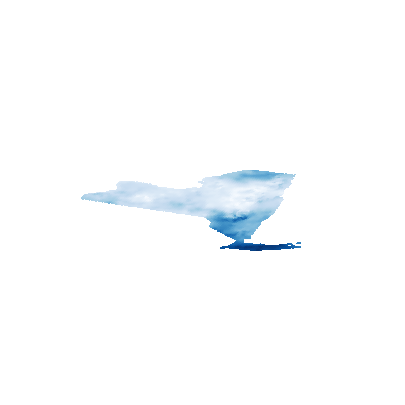

In [13]:
import rasterio
from rasterio.enums import Resampling
from rasterio import mask as rio_mask
from rasterio.warp import reproject, Resampling as WarpResampling, transform_bounds
import rasterio.transform as rio_transform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

# -------------------------------------------------
# INPUTS
# -------------------------------------------------
# Assumes you already have: DEM_path, state_shapefile, HUC12_shapfile,
# stream_shapefile_simple, culvert_shapefile, road_shapefile,
# street_shapefile_simple, railroad_shapefile
landuse_path = r"D:\hydrological analysis\data\CN\CONUS_Landcover\CONUS_Landcover_A2\CONUS_A2_y2100.tif"
idf_file = 'ne50yr60ma_ams.asc'
idf_path = rf"D:\culvert repo\data\NOAA IDF\{folder}\{idf_file}"

# -------------------------------------------------
# DEM (downsampled + masked, CRS anchor)
# -------------------------------------------------
with rasterio.open(DEM_path) as src:
    H, W = src.height, src.width
    bounds = src.bounds
    dem_crs = src.crs

    target_pixels = 6_000_000
    scale = max(1.0, np.sqrt((H * W) / target_pixels))
    out_h = max(1, int(H / scale))
    out_w = max(1, int(W / scale))

    dem = src.read(
        1,
        out_shape=(out_h, out_w),
        resampling=Resampling.average,
        masked=True,
    ).astype("float32")

extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

# -------------------------------------------------
# LANDUSE raster (clip to state, reproject to DEM CRS)
# -------------------------------------------------
landuse_colors = {
    0: 'black', 1: 'blue', 2: 'red', 3: 'burlywood', 4: 'peachpuff',
    5: 'tan', 6: 'brown', 7: 'lightgray', 8: 'mediumseagreen',
    9: 'darkolivegreen', 10: 'chartreuse', 11: 'lightgoldenrodyellow',
    12: 'darkkhaki', 13: 'darkseagreen', 14: 'palegreen',
    15: 'aquamarine', 16: 'mediumaquamarine', 17: 'snow',
}
landuse_cmap = mcolors.ListedColormap([landuse_colors[k] for k in sorted(landuse_colors.keys())])
landuse_norm = mcolors.BoundaryNorm(np.arange(-0.5, 17.5 + 1, 1), landuse_cmap.N)

with rasterio.open(landuse_path) as lu_src:
    state_for_mask = state_shapefile.to_crs(lu_src.crs)
    out_img, out_transform = rio_mask.mask(lu_src, state_for_mask.geometry, crop=True)
    lu_nodata = lu_src.nodata

    landuse_native = np.ma.array(out_img[0], mask=(out_img[0] == lu_nodata) if lu_nodata is not None else False)

    HH, WW = landuse_native.shape
    target_pixels = 6_000_000
    lu_scale = max(1.0, np.sqrt((HH * WW) / target_pixels))
    lu_h = max(1, int(HH / lu_scale))
    lu_w = max(1, int(WW / lu_scale))

    left, bottom, right, top = rio_transform.array_bounds(HH, WW, out_transform)
    left_d, bottom_d, right_d, top_d = transform_bounds(lu_src.crs, dem_crs, left, bottom, right, top)
    lu_dst_transform = rio_transform.from_bounds(left_d, bottom_d, right_d, top_d, lu_w, lu_h)

    landuse = np.empty((lu_h, lu_w), dtype=landuse_native.dtype)
    reproject(
        source=landuse_native.filled(lu_nodata if lu_nodata is not None else 255),
        destination=landuse,
        src_transform=out_transform,
        src_crs=lu_src.crs,
        dst_transform=lu_dst_transform,
        dst_crs=dem_crs,
        resampling=WarpResampling.nearest,
        src_nodata=lu_nodata,
        dst_nodata=lu_nodata,
    )
    landuse = np.ma.array(landuse, mask=(landuse == lu_nodata) if lu_nodata is not None else False)
    landuse_extent = (left_d, right_d, bottom_d, top_d)

# -------------------------------------------------
# IDF ASCII raster (mask outside state to NoData, reproject to DEM CRS)
# -------------------------------------------------
with rasterio.open(idf_path) as idf_src:
    # ensure polygon CRS matches raster before masking
    state_in_idf_crs = state_shapefile.to_crs(idf_src.crs) if state_shapefile.crs != idf_src.crs else state_shapefile

    idf_nodata = idf_src.nodata if idf_src.nodata is not None else -9999
    # set outside-of-state to NoData; keep full original extent (crop=False)
    idf_img, idf_transform = rio_mask.mask(
        idf_src,
        list(state_in_idf_crs.geometry),
        crop=False,
        filled=True,
        nodata=idf_nodata,
    )
    idf_native = np.ma.array(idf_img[0], mask=(idf_img[0] == idf_nodata))

    HH, WW = idf_native.shape
    target_pixels = 6_000_000
    idf_scale = max(1.0, np.sqrt((HH * WW) / target_pixels))
    idf_h = max(1, int(HH / idf_scale))
    idf_w = max(1, int(WW / idf_scale))

    # reproject full (masked) grid to DEM CRS
    left, bottom, right, top = idf_src.bounds  # full extent
    left_d, bottom_d, right_d, top_d = transform_bounds(idf_src.crs, dem_crs, left, bottom, right, top)
    idf_dst_transform = rio_transform.from_bounds(left_d, bottom_d, right_d, top_d, idf_w, idf_h)

    idf = np.empty((idf_h, idf_w), dtype=np.float32)
    reproject(
        source=idf_native.filled(idf_nodata).astype(np.float32),
        destination=idf,
        src_transform=idf_transform,
        src_crs=idf_src.crs,
        dst_transform=idf_dst_transform,
        dst_crs=dem_crs,
        resampling=WarpResampling.bilinear,  # continuous values
        src_nodata=idf_nodata,
        dst_nodata=idf_nodata,
    )
    idf = np.ma.array(idf, mask=(idf == idf_nodata))
    idf_extent = (left_d, right_d, bottom_d, top_d)

# -------------------------------------------------
# Reproject vectors to DEM CRS (for overlay)
# -------------------------------------------------
state_shapefile = state_shapefile.to_crs(dem_crs)
HUC12_shapfile = HUC12_shapfile.to_crs(dem_crs)
stream_shapefile_simple = stream_shapefile_simple.to_crs(dem_crs)
culvert_shapefile = culvert_shapefile.to_crs(dem_crs)
road_shapefile = road_shapefile.to_crs(dem_crs)
street_shapefile_simple = street_shapefile_simple.to_crs(dem_crs)
railroad_shapefile = railroad_shapefile.to_crs(dem_crs)

# -------------------------------------------------
# Layers (stack order) — added IDF with Blues
# -------------------------------------------------
layers = [
    # ("DEM", dem, {"cmap": "gray_r", "extent": extent}),
    #("Landuse", landuse, {"cmap": landuse_cmap, "norm": landuse_norm, "extent": landuse_extent}),
    ("IDF", idf, {"cmap": "Blues", "extent": idf_extent}),  # <--- NEW LAYER
    # ("Stream", stream_shapefile_simple, {"color": "blue", "linewidth": 0.05, "alpha": 1}),
    # ("Culverts", culvert_shapefile, {"color": "red", "s": 0.1, "alpha": 1, "marker": "o", "linewidth": 0}),
]

# -------------------------------------------------
# Style helpers
# -------------------------------------------------
def style_for_line(style: dict) -> dict:
    out = {}
    out["color"] = style.get("color", style.get("edgecolor", "k"))
    out["linewidth"] = style.get("linewidth", 0.2)
    if "linestyle" in style:
        out["linestyle"] = style["linestyle"]
    if "alpha" in style:
        out["alpha"] = style["alpha"]
    out.setdefault("zorder", 5)
    return out

def style_for_scatter(style: dict) -> dict:
    out = {}
    out["c"] = style.get("color", style.get("edgecolor", "k"))
    out["s"] = style.get("s", 1)
    if "marker" in style:
        out["marker"] = style["marker"]
    if "alpha" in style:
        out["alpha"] = style["alpha"]
    out["linewidths"] = style.get("linewidth", 0)
    out.setdefault("zorder", 6)
    return out

# -------------------------------------------------
# Axes extents (from DEM)
# -------------------------------------------------
minx, miny, maxx, maxy = extent[0], extent[2], extent[1], extent[3]

# -------------------------------------------------
# Figure
# -------------------------------------------------
fig = plt.figure(figsize=(3*2, 2.5*2))
ax = fig.add_subplot(111, projection="3d")
# ax.set_proj_type('ortho')  # optional

VERTICAL_GAP = 0.06
z_spacing = VERTICAL_GAP * (maxy - miny)

# -------------------------------------------------
# Plot
# -------------------------------------------------
for i, (label, data, base_style) in enumerate(layers):
    base_z = i * z_spacing
    z_level = base_z if label in ("DEM", "Landuse", "IDF") else base_z + 1e-6  # rasters at base; vectors above

    if label in ("DEM", "Landuse", "IDF"):
        data_plot = np.flipud(data)  # orientation consistent
        ext = base_style.get("extent", extent)

        # Optional decimation for speed (keeps ≤ ~400 px per side)
        nrows, ncols = data_plot.shape
        max_side = 400
        rstep = max(1, nrows // max_side)
        cstep = max(1, ncols // max_side)
        data_small = data_plot[::rstep, ::cstep]
        xs = np.linspace(ext[0], ext[1], ncols)[::cstep]
        ys = np.linspace(ext[2], ext[3], nrows)[::rstep]
        X, Y = np.meshgrid(xs, ys)

        cmap = base_style.get("cmap", "gray_r")
        cmap = plt.get_cmap(cmap) if isinstance(cmap, str) else cmap
        norm = base_style.get("norm", Normalize(vmin=np.nanmin(data_small), vmax=np.nanmax(data_small)))

        rgba = cmap(norm(data_small))
        rgba = np.asarray(rgba)
        if np.ma.is_masked(data_small):
            rgba[..., -1] = np.where(data_small.mask, 0.0, 1.0)
        else:
            rgba[..., -1] = 1.0

        ax.plot_surface(
            X, Y, np.full_like(data_small, z_level, dtype=float),
            facecolors=rgba, rstride=1, cstride=1,
            linewidth=0, antialiased=False, shade=False, zorder=0,
        )

    else:
        line_kwargs = style_for_line(base_style)
        scat_kwargs = style_for_scatter(base_style)
        for geom in data.geometry:
            if geom is None:
                continue
            gt = geom.geom_type
            if gt == "Polygon":
                xs, ys = geom.exterior.xy
                ax.plot(xs, ys, z_level, **line_kwargs)
                for interior in geom.interiors:
                    xs, ys = interior.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "MultiPolygon":
                for poly in geom.geoms:
                    xs, ys = poly.exterior.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
                    for interior in poly.interiors:
                        xs, ys = interior.xy
                        ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "LineString":
                xs, ys = geom.xy
                ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "MultiLineString":
                for line in geom.geoms:
                    xs, ys = line.xy
                    ax.plot(xs, ys, z_level, **line_kwargs)
            elif gt == "Point":
                ax.scatter([geom.x], [geom.y], [z_level], **scat_kwargs)
            elif gt == "MultiPoint":
                xs = [p.x for p in geom.geoms]
                ys = [p.y for p in geom.geoms]
                zs = [z_level] * len(xs)
                ax.scatter(xs, ys, zs, **scat_kwargs)

# -------------------------------------------------
# Styling
# -------------------------------------------------
padx = 0.005 * (maxx - minx)
pady = 0.005 * (maxy - miny)
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
ax.set_zlim(0, len(layers) * z_spacing)

ax.set_box_aspect((maxx - minx, maxy - miny, z_spacing * len(layers)))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zticks([]); ax.set_zticklabels([])
ax.zaxis.line.set_visible(False)
ax.set_zlabel("")

ax.view_init(elev=25, azim=-60)
ax.grid(False)
ax.set_axis_off()

plt.savefig(r'C:\Users\Omid Emamjomehzadeh\Desktop\data figures\Rainfall.png',
            dpi=300, bbox_inches='tight')
plt.show()


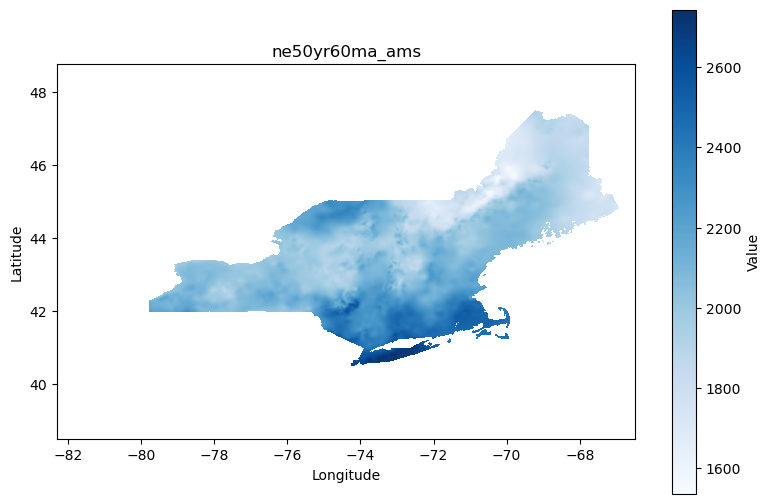

In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
folder = f'ne50yr60ma_ams'
file = 'ne50yr60ma_ams.asc'
asc_file = rf"D:\culvert repo\data\NOAA IDF\{folder}\{file}"

with rasterio.open(asc_file) as src:
    arr = src.read(1, masked=True)
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    nodata = src.nodata

# If nodata is defined but the mask didn't pick it up:
if nodata is not None:
    arr = np.ma.masked_equal(arr, nodata)

plt.figure(figsize=(8, 6))
im = plt.imshow(arr, extent=extent, origin="upper", cmap="Blues", interpolation="nearest")
cbar = plt.colorbar(im, shrink=0.85)
cbar.set_label("Value")
plt.title("ne50yr60ma_ams")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


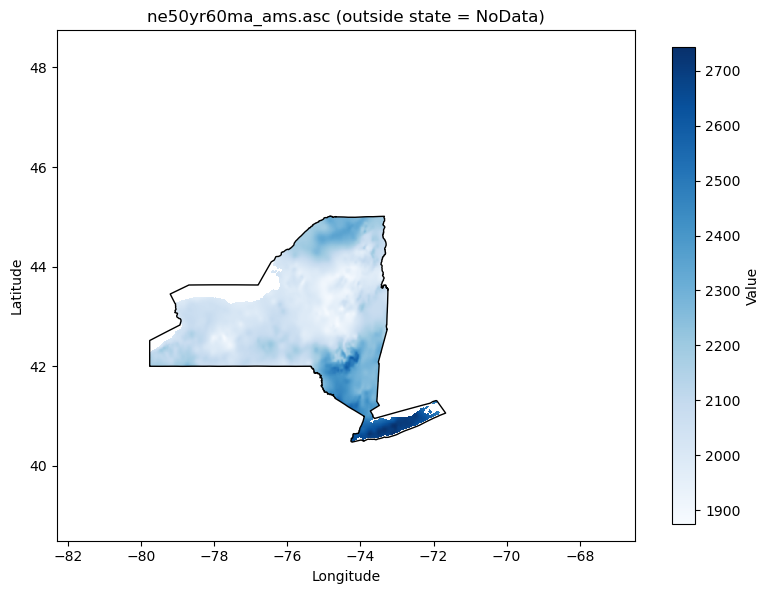

In [20]:
import rasterio
from rasterio import mask as rio_mask
import numpy as np
import matplotlib.pyplot as plt

file = 'ne50yr60ma_ams.asc'
asc_file = rf"D:\culvert repo\data\NOAA IDF\{folder}\{file}"

with rasterio.open(asc_file) as src:
    # match CRS
    state_in_raster_crs = state_shapefile.to_crs(src.crs) if state_shapefile.crs != src.crs else state_shapefile

    # mask: set outside shapes to nodata, keep original extent (crop=False)
    nodata = src.nodata if src.nodata is not None else -9999
    out_img, out_transform = rio_mask.mask(
        src,
        list(state_in_raster_crs.geometry),
        crop=False,        # keep full raster extent; set outside to nodata
        filled=True,
        nodata=nodata
    )

    arr = out_img[0]
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

# mask nodata for plotting transparency
arr_m = np.ma.masked_equal(arr, nodata)

plt.figure(figsize=(8, 6))
im = plt.imshow(arr_m, extent=extent, origin="upper", cmap="Blues", interpolation="nearest")
plt.colorbar(im, shrink=0.9, label="Value")
state_in_raster_crs.boundary.plot(ax=plt.gca(), edgecolor="black", linewidth=1)
plt.title(f"{file} (outside state = NoData)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


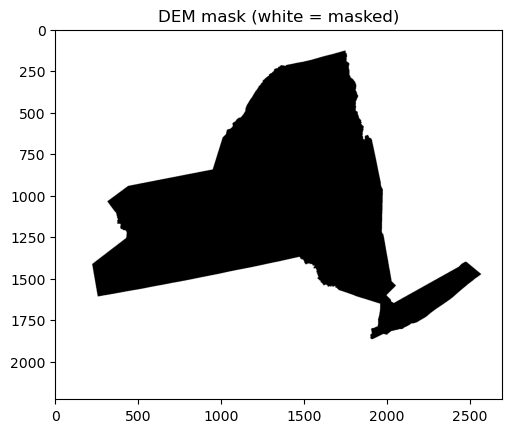

In [ ]:
plt.figure(); plt.imshow(dem.mask, origin="upper", cmap="gray")
plt.title("DEM mask (white = masked)"); plt.show()

In [26]:
print("DEM extent:", dem_extent)
print("Vector extent:", (vx_minx, vx_miny, vx_maxx, vx_maxy))
print("DEM masked%:", np.mean(getattr(dem, "mask", np.zeros_like(dem, dtype=bool))) * 100)

DEM extent: (1253760.042117101, 1282205.3085176733, 2672953.3402566183, 2696476.4031136828)
Vector extent: (np.float64(1319547.040447661), np.float64(2149150.462257089), np.float64(2006512.5413029226), np.float64(2658548.125730891))
DEM masked%: 72.50742874598299


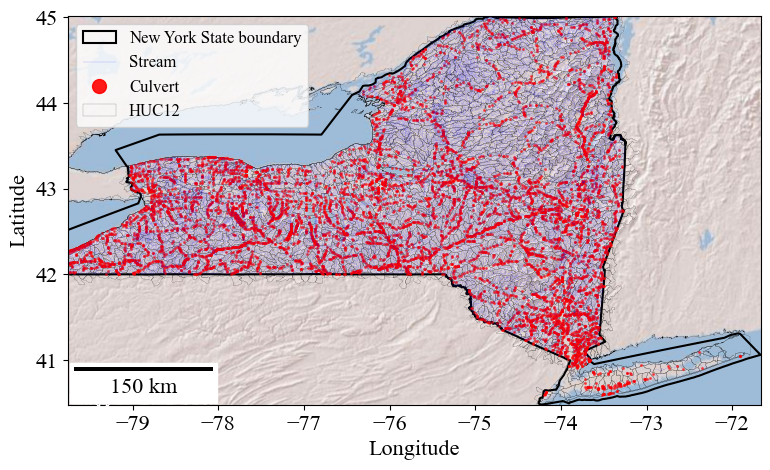

In [8]:
# Font setup
font = {'family': 'Times New Roman', 'size': 16}
plt.rc('font', **font)

# Set CRS
crs_deg = 'EPSG:4326'
crs_m = 'EPSG:5070'

# Reproject all data to 4326 for plotting
state_shapefile = state_shapefile.to_crs(crs_deg)
HUC12_shapfile = HUC12_shapfile.to_crs(crs_deg)
culvert_shapefile = culvert_shapefile.to_crs(crs_deg)
stream_shapefile = stream_shapefile.to_crs(crs_deg)

# Compute bounds and figure size for correct aspect
minx, miny, maxx, maxy = state_shapefile.total_bounds
data_width = maxx - minx
data_height = maxy - miny
aspect_ratio = data_width / data_height
fig_width = 9
fig_height = fig_width / aspect_ratio

# Create figure and axis in EPSG:4326
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot layers
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')
HUC12_shapfile.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor='none')
culvert_shapefile.plot(ax=ax, color='red', markersize=1.5, alpha=0.5, marker='o', linestyle='None')
stream_shapefile.plot(ax=ax, color='blue', linewidth=0.1, alpha=0.5)

# Basemap in 4326-compatible projection
ctx.add_basemap(ax, crs=state_shapefile.crs, source=ctx.providers.Esri.WorldShadedRelief)

# Legend
legend_handles = [
    mpatches.Patch(edgecolor='black', facecolor='none', linewidth=1.5, label='New York State boundary'),
    Line2D([0], [0], color='blue', lw=0.3, alpha=0.3, label='Stream'),
    Line2D([0], [0], marker='o', color='red', markersize=10, alpha=0.9, linestyle='None', label='Culvert'),
    mpatches.Patch(edgecolor='black', facecolor='none', linewidth=0.1, label='HUC12')
]
ax.legend(handles=legend_handles, loc='upper left', prop={'family': 'Times New Roman', 'size': 12}, frameon=True)

# ----- Scale Bar Trick: Add dummy axis for EPSG:5070 -----
# Transform a representative region to 5070 for accurate scale
import geopandas as gpd
from shapely.geometry import box

# Create bounding box geometry to estimate scale
bbox_geom = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs=crs_deg)
bbox_5070 = bbox_gdf.to_crs(crs_m)
# Get scale in meters per degree approx.
scale_width_m = bbox_5070.geometry[0].bounds[2] - bbox_5070.geometry[0].bounds[0]
scale_width_deg = maxx - minx
meters_per_degree = scale_width_m / scale_width_deg

# Add scale bar assuming ~meters per degree
scalebar = ScaleBar(dx=1*meters_per_degree, units="m", dimension="si-length", location="lower left", scale_loc="bottom")
ax.add_artist(scalebar)

# Save and show
plt.savefig(r'D:\culvert repo\Results\Figures\initial_layers_basemap_with_scale.png', dpi=300)
plt.show()

# Main waterhseds (HUC8)

C:\Users\Omid Emamjomehzadeh\AppData\Local\Temp\ipykernel_26740\4183769639.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c', num_polygons)


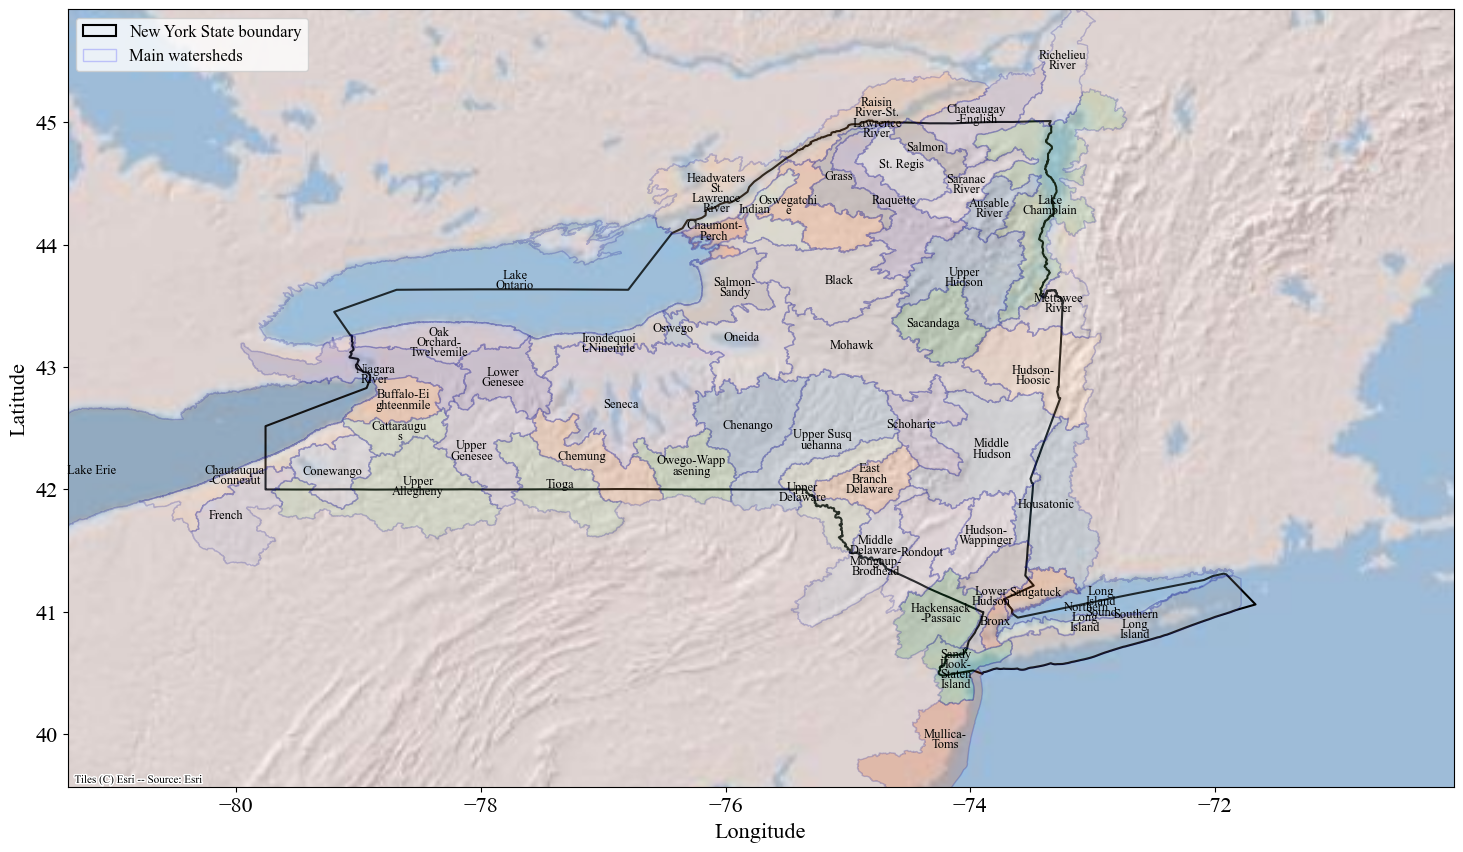

In [ ]:
# Load shapefiles
huc8_shapefile = gpd.read_file(r"D:\culvert repo\data\Watershed_Boundary_HUC_8\Watershed_Boundary_HUC_8.shp").to_crs(epsg=4326)
# Set font
plt.rc('font', family='Times New Roman', size=16)
# Compute figure aspect ratio
minx, miny, maxx, maxy = state_shapefile.total_bounds
margin_x = (maxx - minx) * 0.2
margin_y = (maxy - miny) * 0.2
# Expand the bounds
minx_expanded = minx - margin_x
maxx_expanded = maxx + margin_x
miny_expanded = miny - margin_y
maxy_expanded = maxy + margin_y

# Compute expanded dimensions
data_width = maxx_expanded - minx_expanded
data_height = maxy_expanded - miny_expanded
aspect_ratio = data_width / data_height
fig_width = 18
fig_height = fig_width / aspect_ratio
# Create figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
# Set limits and axis labels
ax.set_xlim(minx - margin_x, maxx + margin_x)
ax.set_ylim(miny - margin_y, maxy + margin_y)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Plot layers
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none', label='New York state boundary')
# Plot HUC 8 boundaries
# Number of HUC-8 polygons
num_polygons = len(huc8_shapefile)
# Generate and shuffle unique indices
np.random.seed(42)
random_indices = np.random.permutation(num_polygons)
# Generate colormap and shuffled indices
num_polygons = len(huc8_shapefile)
cmap = cm.get_cmap('tab20c', num_polygons)
random_indices = np.random.permutation(num_polygons)
# Create a mapping from original index to color
index_to_color = {}
# Plot polygons with random colors (alpha=0.1) and store their color
for plot_idx, data_idx in enumerate(random_indices):
    color = cmap(plot_idx)
    index_to_color[data_idx] = color  # Save color for labeling
    huc8_shapefile.iloc[[data_idx]].plot(
        ax=ax,
        facecolor=color,
        edgecolor='darkblue',
        linewidth=1,
        alpha=0.2
    )
# Plot labels using the same color (alpha=1)
for idx, row in huc8_shapefile.iterrows():
    if row.geometry.is_empty:
        continue
    point = row.geometry.representative_point()
    x, y = point.x, point.y
    name = row['name']
    wrapped_name = "\n".join(textwrap.wrap(name, width=10))

    color = index_to_color[idx]  # Retrieve color
    ax.text(x, y, wrapped_name, fontsize=9, ha='center', va='center',
            linespacing=0.8, color='black', alpha=1)  # Ignore alpha in text

# Add basemap
ctx.add_basemap(ax, crs=state_shapefile.crs, source=ctx.providers.Esri.WorldShadedRelief)
# Legend
legend_handles = [
    mpatches.Patch(edgecolor='black', facecolor='none', linewidth=1.5, label='New York state boundary'),
    mpatches.Patch(edgecolor='blue', facecolor='none', linewidth=1, alpha=0.2, label='Main watersheds')
]
ax.legend(handles=legend_handles, loc='upper left', prop={'family': 'Times New Roman', 'size': 12}, frameon=True)
# Save and show
plt.savefig(r'D:\culvert repo\Results\Figures\NYS_HUC8_watersheds.png', dpi=300)
plt.show()

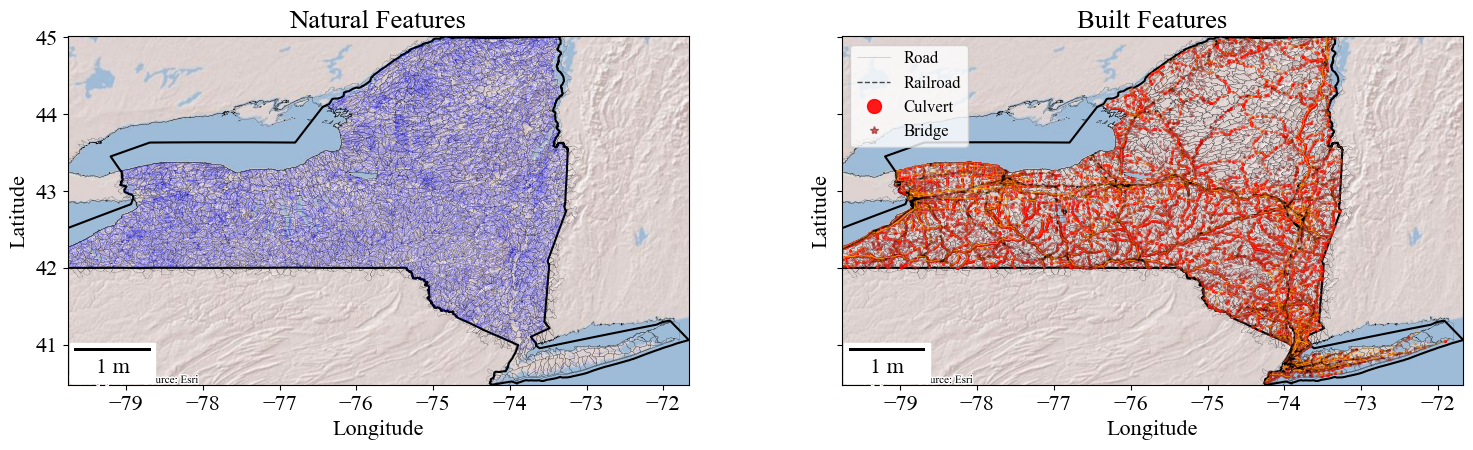

In [ ]:
# Set CRS
crs_epsg = 4326
for shp in [state_shapefile, road_shapefile, culvert_shapefile, stream_shapefile,
            HUC12_shapfile, bridge_shapefile, railroad_shapefile, street_shapefile,
            stream_highres_shapefile]:
    shp.to_crs(epsg=crs_epsg, inplace=True)

# Set font
plt.rc('font', family='Times New Roman', size=16)

# Compute aspect ratio
minx, miny, maxx, maxy = state_shapefile.total_bounds
data_width = maxx - minx
data_height = maxy - miny
aspect_ratio = data_width / data_height
fig_width = 16
fig_height = fig_width / (2 * aspect_ratio)  # Half because we have two plots side by side

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, fig_height), sharex=True, sharey=True)

for ax in [ax1, ax2]:
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# === Natural Features ===
state_shapefile.plot(ax=ax1, edgecolor='black', linewidth=1.5, facecolor='none')
HUC12_shapfile.plot(ax=ax1, edgecolor='black', linewidth=0.1, facecolor='none')
stream_shapefile.plot(ax=ax1, color='blue', linewidth=0.2, alpha=0.5)

ax1.set_title("Natural Features")
ctx.add_basemap(ax1, crs=state_shapefile.crs, source=ctx.providers.Esri.WorldShadedRelief)

# === Built Features ===
state_shapefile.plot(ax=ax2, edgecolor='black', linewidth=1.5, facecolor='none')
HUC12_shapfile.plot(ax=ax2, edgecolor='black', linewidth=0.1, facecolor='none')
culvert_shapefile.plot(ax=ax2, color='red', markersize=1.5, alpha=0.5, marker='o', linestyle='None')
road_shapefile.plot(ax=ax2, color='orange', linewidth=0.5, alpha=0.3)
railroad_shapefile.plot(ax=ax2, color='black', linewidth=1, alpha=0.3, linestyle='dashed')
bridge_shapefile.plot(ax=ax2, color='brown', markersize=1, alpha=0.3, marker='*', linestyle='None')

ax2.set_title("Built Features")
ctx.add_basemap(ax2, crs=state_shapefile.crs, source=ctx.providers.Esri.WorldShadedRelief)

# Legends
ax2.legend(handles=[
    Line2D([0], [0], color='orange', lw=0.5, alpha=0.7, label='Road'),
    Line2D([0], [0], color='black', lw=1, alpha=0.7, linestyle='dashed', label='Railroad'),
    Line2D([0], [0], marker='o', color='red', markersize=10, alpha=0.9, linestyle='None', label='Culvert'),
    Line2D([0], [0], marker='*', color='brown', markersize=6, alpha=0.7, linestyle='None', label='Bridge'),
], loc='upper left', prop={'size': 12}, frameon=True)

# Scale bars
scalebar1 = ScaleBar(1, units="m", dimension="si-length", location="lower left", scale_loc="bottom")
scalebar2 = ScaleBar(1, units="m", dimension="si-length", location="lower left", scale_loc="bottom")
ax1.add_artist(scalebar1)
ax2.add_artist(scalebar2)

# Save and show
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\natural_vs_built_features.png', dpi=300)
plt.show()


# Clip

In this section, each layer is clipped based on HUC12s, this operation prepares the files for parallel computing.

In [6]:
base_dir=r'D:\culvert repo\Results\Clipped_layers'

#Define output file path
output_huc12_dir = rf"{base_dir}\clipped_huc12"
output_stream_dir = rf"{base_dir}\clipped_streams"
output_road_dir = rf"{base_dir}\clipped_roads"
output_street_dir = rf"{base_dir}\clipped_street"
output_railroad_dir = rf"{base_dir}\clipped_railroad"
output_culvert_dir = rf"{base_dir}\clipped_culverts"
output_DEM_dir=rf"{base_dir}\HUC12_one meter_DEM"

# Ensure the output directories exist
os.makedirs(output_huc12_dir, exist_ok=True)
os.makedirs(output_stream_dir, exist_ok=True)
os.makedirs(output_road_dir, exist_ok=True)
os.makedirs(output_street_dir, exist_ok=True)
os.makedirs(output_railroad_dir, exist_ok=True)
os.makedirs(output_culvert_dir, exist_ok=True)
os.makedirs(output_DEM_dir, exist_ok=True)

In [7]:
state_shapefile = state_shapefile.to_crs(epsg=5070)
road_shapefile = road_shapefile.to_crs(epsg=5070)
culvert_shapefile = culvert_shapefile.to_crs(epsg=5070)
stream_shapefile = stream_shapefile.to_crs(epsg=5070)
HUC12_shapfile=HUC12_shapfile.to_crs(epsg=5070)
bridge_shapefile=bridge_shapefile.to_crs(epsg=5070)
railroad_shapefile=railroad_shapefile.to_crs(epsg=5070)
street_shapefile=street_shapefile.to_crs(epsg=5070)
stream_highres_shapefile=stream_highres_shapefile.to_crs(epsg=5070)

In [34]:
# Convert datetime fields to date only
HUC12_shapfile['loaddate'] = pd.to_datetime(HUC12_shapfile['loaddate'], errors='coerce').dt.date

# Suppress specific RuntimeWarnings from pyogrio
warnings.filterwarnings("ignore", message="Field .* create as date field, though DateTime requested")
# Iterate over each HUC12 and clipe all initial layers
for idx, row in tqdm(HUC12_shapfile.iterrows(), total=HUC12_shapfile.shape[0], desc="Processing HUC12 regions"):
    polygon = row['geometry']
    huc12 = row['huc12']

    # HUC12 
    huc12_gdf = gpd.GeoDataFrame([row], columns=HUC12_shapfile.columns, crs=HUC12_shapfile.crs)
    # Save the HUC12 
    output_huc12_path = os.path.join(output_huc12_dir, f'{huc12}_huc12.shp')
    huc12_gdf.to_file(output_huc12_path)
    
    # Stream 
    clipped_streams = stream_highres_shapefile[stream_highres_shapefile.intersects(polygon)]
    clipped_streams = gpd.clip(clipped_streams, polygon)
    if not clipped_streams.empty:
        output_stream_path = os.path.join(output_stream_dir, f'{huc12}_streams.shp')
        clipped_streams.to_file(output_stream_path)
    
    # Road 
    clipped_roads = road_shapefile[road_shapefile.intersects(polygon)]
    clipped_roads = gpd.clip(clipped_roads, polygon)
    if not clipped_roads.empty:
        output_road_path = os.path.join(output_road_dir, f'{huc12}_roads.shp')
        clipped_roads.to_file(output_road_path)

    # Railroad
    clipped_railroads = railroad_shapefile[railroad_shapefile.intersects(polygon)]
    clipped_railroads = gpd.clip(clipped_railroads, polygon)
    if not clipped_railroads.empty:
        output_railroad_path = os.path.join(output_railroad_dir, f'{huc12}_railroads.shp')
        clipped_railroads.to_file(output_railroad_path)

    # Street 
    clipped_streets = street_shapefile[street_shapefile.intersects(polygon)]
    clipped_streets = gpd.clip(clipped_streets, polygon)
    if not clipped_roads.empty:
        output_street_path = os.path.join(output_street_dir, f'{huc12}_streets.shp')
        clipped_roads.to_file(output_street_path)
    
    # Culvert
    clipped_culverts = culvert_shapefile[culvert_shapefile.intersects(polygon)]
    clipped_culverts = gpd.clip(clipped_culverts, polygon)
    if not clipped_culverts.empty:
        output_culvert_path = os.path.join(output_culvert_dir, f'{huc12}_culverts.shp')
        clipped_culverts.to_file(output_culvert_path)

Processing HUC12 regions: 100%|████████████████████████████████████████████████████| 1685/1685 [20:17<00:00,  1.38it/s]


In [8]:
# Calulate percent and list of HUCs that have all the required layers
huc12_with_all_layers = []
huc12_with_culvert=[]
# Iterate over each HUC12 
for idx, row in HUC12_shapfile.iterrows():
    huc12 = row['huc12']
    
    # Check if the corresponding clipped shapefiles exist
    clipped_streams_file = os.path.join(output_stream_dir, f'{huc12}_streams.shp')
    clipped_roads_file = os.path.join(output_road_dir, f'{huc12}_roads.shp')
    clipped_streets_file = os.path.join(output_street_dir, f'{huc12}_streets.shp')
    clipped_culverts_file = os.path.join(output_culvert_dir, f'{huc12}_culverts.shp')
    
    if os.path.exists(clipped_streams_file) and (os.path.exists(clipped_roads_file) or os.path.exists(clipped_streets_file))  and os.path.exists(clipped_culverts_file):
        huc12_with_all_layers.append(huc12)
    if os.path.exists(clipped_culverts_file):
        huc12_with_culvert.append(huc12)

# Calculate the percentage of HUC12 regions that have all the corresponding layers
total_huc12 = len(HUC12_shapfile)
huc12_with_all_layers_count = len(huc12_with_all_layers)
percentage_with_all_layers = (huc12_with_all_layers_count / len(huc12_with_culvert)) * 100

print(f'Total HUC12 regions: {total_huc12}')
print(f'HUC12 regions with culverts: {len(huc12_with_culvert)}')
print(f'HUC12 regions with culverts, roads, and stream layers: {huc12_with_all_layers_count}')
print(f'Percentage of HUC12 regions with culverts, roads, and stream layers: {percentage_with_all_layers:.2f}%')

# Save the list of HUC12 with all layers
output_list_path = r'D:\culvert repo\Results\Lists\huc12_with_all_layers.txt'
with open(output_list_path, 'w') as file:
    for huc12 in huc12_with_all_layers:
        file.write(f'{huc12}\n')
print(f'List of HUC12 regions with all layers saved to {output_list_path}')

Total HUC12 regions: 1685
HUC12 regions with culverts: 1242
HUC12 regions with culverts, roads, and stream layers: 1234
Percentage of HUC12 regions with culverts, roads, and stream layers: 99.36%
List of HUC12 regions with all layers saved to D:\culvert repo\Results\Lists\huc12_with_all_layers.txt


# Plot the cliped watersheds

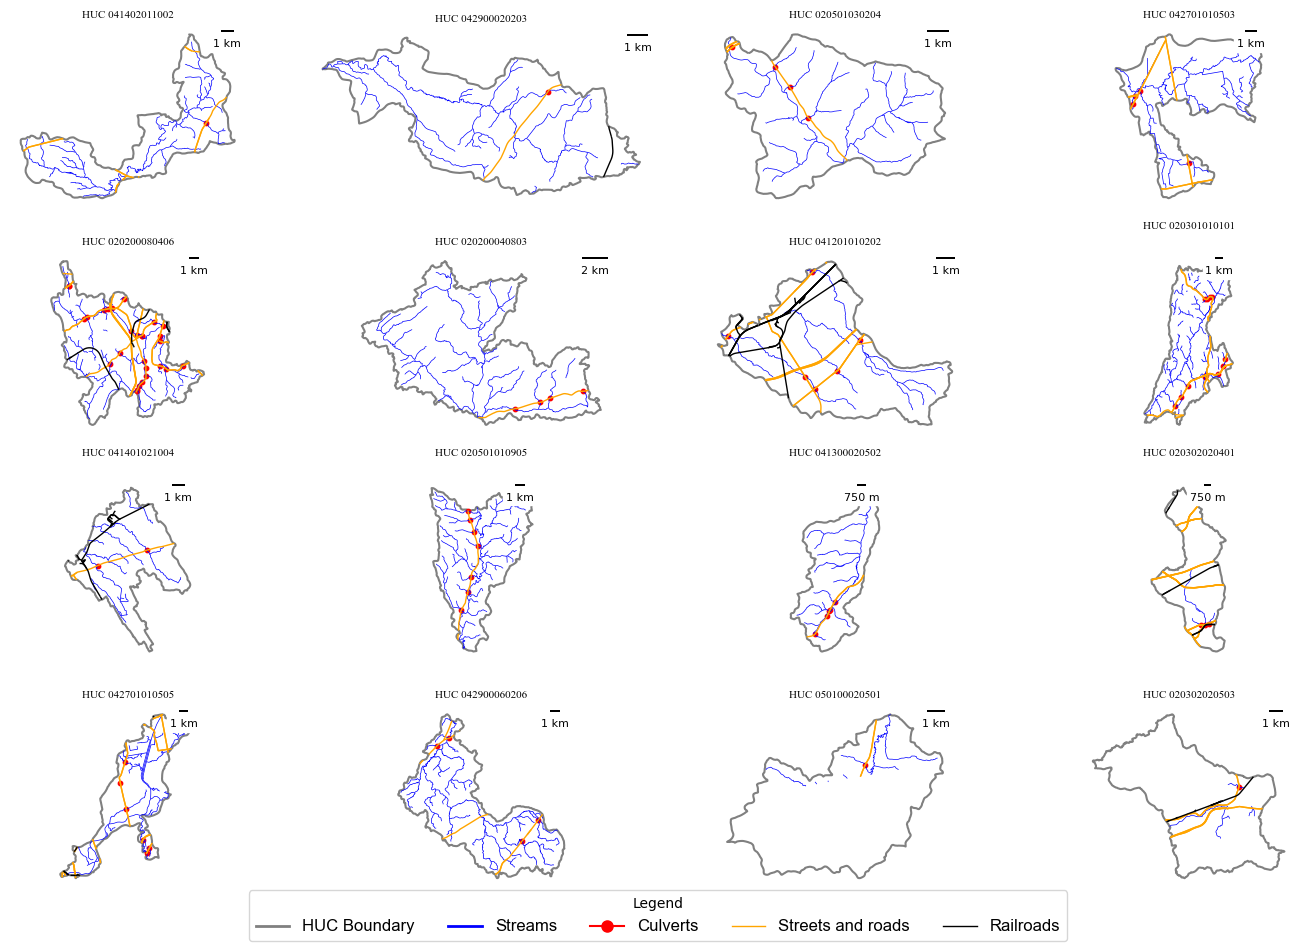

CPU times: total: 9.95 s
Wall time: 19.6 s


In [26]:
%%time
# Function to read HUC list
def read_huc_list(file_path):
    with open(file_path, 'r') as file:
        huc_list = [line.strip() for line in file.readlines()]
    return huc_list

# Read the list of HUCs
huc_list = read_huc_list(output_list_path)

# Randomly select six HUCs
selected_hucs = random.sample(huc_list, 20)

# Initialize empty lists to store dataframes
huc12_list, streams_list, culverts_list, roads_list, streets_list, railroads_list = [], [], [], [], [], []

# Paths to specific files for each selected HUC
for huc in selected_hucs:
    def load_shapefile(filepath):
        return gpd.read_file(filepath) if os.path.exists(filepath) else gpd.GeoDataFrame()

    output_huc12_path = os.path.join(output_huc12_dir, f'{huc}_huc12.shp')
    output_stream_path = os.path.join(output_stream_dir, f'{huc}_streams.shp')
    output_culvert_path = os.path.join(output_culvert_dir, f'{huc}_culverts.shp')
    output_road_path = os.path.join(output_road_dir, f'{huc}_roads.shp')
    output_street_path = os.path.join(output_street_dir, f'{huc}_streets.shp')
    output_railroad_path = os.path.join(output_railroad_dir, f'{huc}_railroads.shp')

    # Load data or fallback to empty GeoDataFrame
    huc12_list.append(load_shapefile(output_huc12_path))
    streams_list.append(load_shapefile(output_stream_path))
    culverts_list.append(load_shapefile(output_culvert_path))
    roads_list.append(load_shapefile(output_road_path))
    streets_list.append(load_shapefile(output_street_path))
    railroads_list.append(load_shapefile(output_railroad_path))

# Plot
ratio=1.2
fig, axs = plt.subplots(4, 4, figsize=(12*ratio, 8*ratio))  # Adjust rows and columns as needed

# Legend elements
legend_elements = [
    plt.Line2D([0], [0], color='gray', lw=2, label='HUC Boundary'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Streams'),
    plt.Line2D([0], [0], marker='o', color='red', markersize=10, label='Culverts'),
    plt.Line2D([0], [0], color='orange', lw=1, label='Streets and roads'),
    plt.Line2D([0], [0], color='black', lw=1, label='Railroads'),
]

# Iterate through each subplot
for i, ax in enumerate(axs.flat):
    if i < len(selected_hucs):
        # Plot only if data is available
        if not huc12_list[i].empty:
            huc12_list[i].plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=1.5)
        if not streams_list[i].empty:
            streams_list[i].plot(ax=ax, color='blue', linewidth=0.5)
        if not culverts_list[i].empty:
            culverts_list[i].plot(ax=ax, color='red', markersize=10)
        if not streets_list[i].empty:
            streets_list[i].plot(ax=ax, color='orange', linewidth=1)
        if not railroads_list[i].empty:
            railroads_list[i].plot(ax=ax, color='black', linewidth=1)

        # Title for each subplot
        ax.set_title(f'HUC {selected_hucs[i]}', fontname='Times New Roman', fontsize=8)

        # Add scale bar, ensuring it doesn't overlay plots
        scalebar = ScaleBar(1, units="m", dimension="si-length", location="upper right",
                            length_fraction=0.1, font_properties={'size': 8}, frameon=True)
        ax.add_artist(scalebar)

        # Add north arrow
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        # Hide axis
        ax.set_axis_off()

# Add legend
fig.legend(
    handles=legend_elements, 
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.05), 
    ncol=6, 
    prop={'family': 'Arial', 'size': 12},
    title= 'Legend',
    markerscale=0.8,
    frameon=True
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  

plt.savefig(r'D:\culvert repo\Results\Figures\Clipped_layers_20_random_HUC12s.png', dpi=300)
plt.show()

In [27]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-04-30 14:34:52.352270


In [28]:
%load_ext watermark
# Print Python version and some dependencies
%watermark -v -m -p rasterio,geopandas,numpy,watermark,random,py3dep,pyproj,matplotlib_scalebar,pandas

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

rasterio           : 1.4.3
geopandas          : 1.0.1
numpy              : 2.0.2
watermark          : 2.4.3
random             : unknown
py3dep             : not installed
pyproj             : 3.7.1
matplotlib_scalebar: 0.9.0
pandas             : 2.2.2

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

